# Upper Confidence Bound 

Reference: 

https://zhuanlan.zhihu.com/p/32335683

Note all contents are included.

In [90]:
import numpy as np 
import pandas as pd 
from scipy import stats

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

from utils.viz import viz 
viz.get_style()

### Bandit problem

Inside a Casino, there are N bandit machines. 

If you pull a bandit machine, it returns either 1 dollar or nothing. We are told that different machines have different rewarding probabilities but have no idea of the exact values. 

How to maximize our reward within T attempts? 

In [120]:
def bandits(agent, params, seed=1234, N=20, T=10000):
    
    rng      = np.random.RandomState(seed)
    p_True   = rng.uniform(low=0, high=1, size=N)
    subj     = agent(N, params)
    rew_hist = []

    for _ in range(T):

        # pull a machine and get reward 
        a = subj.get_act(rng)
        r = rng.binomial(n=1, p=p_True[a])
        rew_hist.append(r)
        subj.update(a, r)

    return np.array(rew_hist)

The simplest way is to randomly pick actions

In [121]:
class rand:
    name = 'random'

    def __init__(self, nA, params):
        self.nA = nA
        self._load_params(params)

    def _load_params(self, params):
        pass
        
    def get_act(self, rng):
        return rng.choice(range(self.nA)) 

    def update(self, a, r):
        pass 

In [122]:
def sim(agent, params, n_sim=20, seed=1234):
    avg_rew_hist = 0 
    for _ in range(n_sim):
        seed += 1
        avg_rew_hist += bandits(agent, params, seed) / n_sim
    return avg_rew_hist

In [133]:
def viz_reward(agent, params, win_sz=40, n_sim=80):   
    rew_hist = sim(agent, params, n_sim=n_sim)
    # simple moving average
    rew_hist = pd.Series(rew_hist).rolling(win_sz
                ).mean().values[win_sz-1:]
    ts = np.arange(1, len(rew_hist)+1)
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=ts, y=rew_hist, 
                    lw=3, color=viz.Red)
    plt.ylim([.4, 1])
    plt.ylabel('reward')
    plt.xlabel('time')
    plt.title(f'{agent.name}, {n_sim} sim. \nsmooth win {win_sz}')

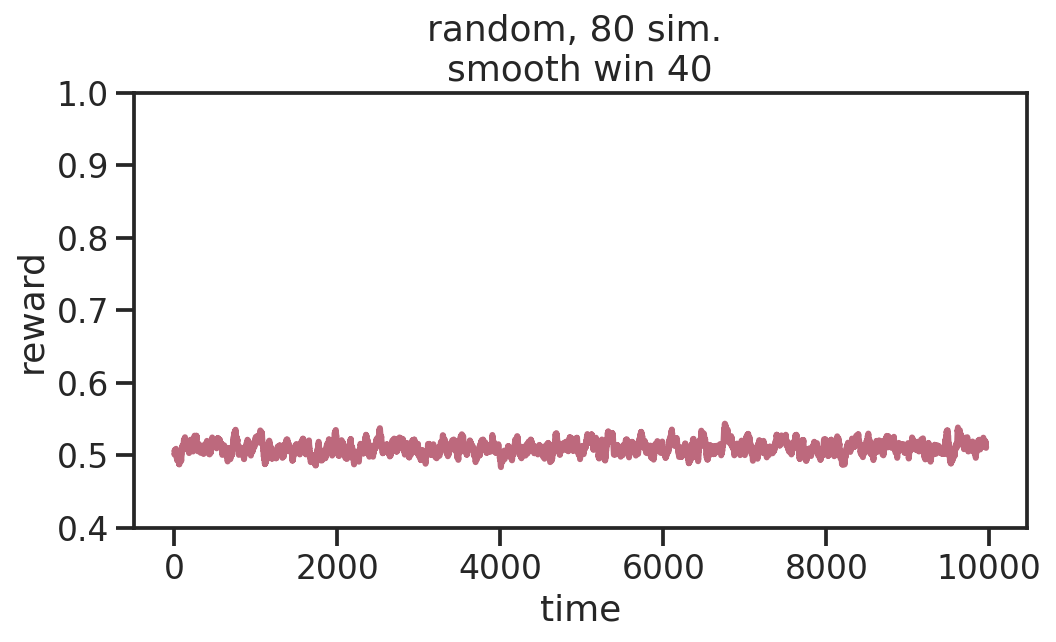

In [134]:

viz_reward(rand, params=[])

### Epsilon-greedy

In [135]:
class egreedy(rand):
    name = 'e-greedy'

    def __init__(self, nA, params):
        super().__init__(nA, params)
        self.v_SA  = np.ones([nA]) / nA

    def _load_params(self, params):
        self.alpha = params[0]
        self.eps   = params[1]

    def update(self, a, r):
        v_Hat = self.v_SA[a]
        self.v_SA[a] += self.alpha*(r - v_Hat)

    def get_act(self, rng):
        if rng.rand() < self.eps:
            a = rng.choice(range(self.nA)) 
        else: 
            a = np.argmax(self.v_SA)
        return a 

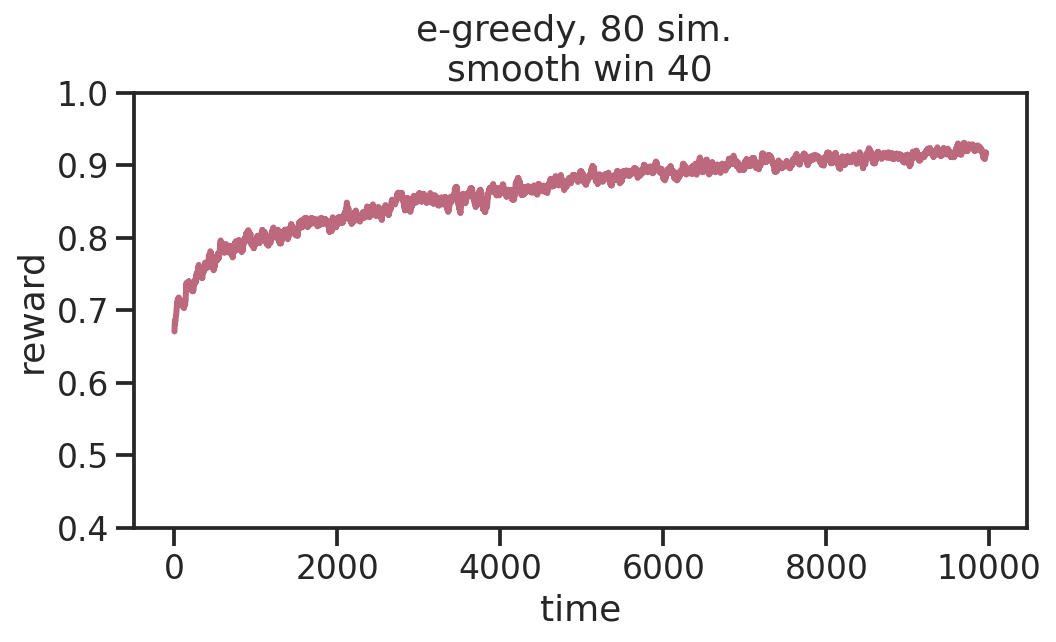

In [136]:
params=[.1, .01]
viz_reward(egreedy, params)

##